## Library

In [1]:
!pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
time: 250 µs (started: 2025-04-30 03:59:06 +00:00)


In [2]:
!pip install openai

time: 2.21 s (started: 2025-04-30 03:59:19 +00:00)


In [9]:
import pandas as pd
from openai import OpenAI
import time
import re

time: 534 µs (started: 2025-04-30 04:36:52 +00:00)


## Data Preparation

In [11]:
df = pd.read_excel("labeled_data.xlsx")
df

,ulasan,rating,label
0,🤮🤢 naikin fee withdrawal FIAT jadi 10K IDR tap...,1,n
1,"Yukk trading di tokocrypto, produk lokal yang ...",5,p
2,Yg saya rasakan menggunakan tokocrypto sangat ...,5,p
3,Yeeyyy akhirnya gak perlu khawatir lagi kalo m...,5,p
4,Yass! Saya sangat merekomendasikan aplikasi in...,5,p
...,...,...,...
2478,1 Fitur yang paling kusuka sih bisa langsung d...,5,p
2479,1 Bintang karena: 1.saya keep eth di tokocrypt...,1,n
2480,"""Tipe Data Salah"" Sudah 3 kali, dari profit me...",1,n
2481,- pelan tapi pasti semua proyeksi di Whitepape...,5,p


time: 125 ms (started: 2025-04-30 04:38:35 +00:00)


In [ ]:
## Import kamus untuk mengubah singkatan
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
## Membuat dictionary untuk memetakan singkatan dari kata
nor_dict = {}
for index, row in kamus_alay.iterrows():
  if row[0] not in nor_dict:
    nor_dict[row[0]] = row[1]
def clean_data(text):
  # 01 Konversi ke huruf kecil semua
  text = text.strip().lower()
  # 02 Menghilangkan tautan www.* atau https?://*
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', text)
  # 03 Menghilangkan @username
  text = re.sub('@[^\s]+','', text)
  # 04 Menghilangkan # dari #kata
  text = re.sub(r'#([^\s]+)', r'\1', text)
  # 05 Menghilangkan tanda !, ?, +, &
  text = re.sub(r'[!&?+%]', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  # 07 Menghilangkan spasi berlebihan
  text = re.sub('[\s]+', ' ', text)
  text = re.sub(r'[ðÿ]', '', text)
  text = re.sub(r'[ðŸ‘]', '', text)
  text = re.sub(r'[ðŸ]', '', text)
  # 08 Menghilangkan emoticon dan semacamnya
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F" # emoticons
                              u"\U0001F300-\U0001F5FF" # symbols & pictographs
                              u"\U0001F680-\U0001F6FF" # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF" # flags (ios)
                              "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Pembersihan kata
  words = text.split()
  tokens=[]
  for ww in words:
      # Memisahkan kata berulang
      for w in re.split(r'[-/\s]\s*', ww):
          # Menghapus huruf berulang yang lebih dari dua kali
          pattern = re.compile(r"(.)\1{1,}", re. DOTALL)
          w = pattern.sub(r"\1\1", w)
          w = w.strip('\'"?,.')
          # Memeriksa apakah suatu kata terbentuk dari minimal dua huruf
          #val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
          if w in nor_dict:
              w = nor_dict[w]
          if w == "rt":
          #or val is None:
              continue
          else:
            tokens.append(w.lower())
  text = " ".join(tokens)
  return text.strip()


# Membuat kolom cleaned sebagai representasi string dari kolom ulasan
df["cleaned"] = df["ulasan"].astype(str)

# Membersihkan teks di kolom cleaned dengan fungsi clean_data
df["cleaned"] = df["cleaned"].map(lambda x: clean_data(x))

# Memfilter baris berdasarkan panjang teks (lebih dari 3 kata)
df = df[df["cleaned"].apply(lambda x: len(x.split()) > 3)]

# Memfilter baris yang tidak mengandung kata-kata tertentu
df = df[~df['cleaned'].str.contains('game|hero|match|epep|player|ping|resolusi', case=False)]

# Menampilkan DataFrame
df

## DeepSeek Sentiment

In [ ]:
# 1. Inisialisasi client DeepSeek
client = OpenAI(
    api_key="DEEPSEEK_API_KEY",  # Ganti dengan API Key kamu
    base_url="https://api.deepseek.com"
)

# 3. Fungsi untuk mendapatkan sentimen dari DeepSeek
def get_sentiment(text):
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "Saya sedang melakukan analisis sentimen terhadap ulasan pelanggan dari sebuah aplikasi exchange crypto bernama tokocrypto."},
            {"role": "user", "content": f"Tentukan sentimen ulasan ini: {text}. Jawab hanya: Positif atau Negatif."}
        ],
        stream=False
    )
    return response.choices[0].message.content.strip()

# 4. Tambahkan kolom sentimen ke DataFrame
df['DeepSeek_Sentiment2'] = df['cleaned'].apply(lambda x: get_sentiment(x))

# 5. Tampilkan hasil
df


## Gemini Sentiment

In [ ]:
import pandas as pd
import requests
import json

# Ganti dengan API key milikmu
API_KEY = "GEMINI_API_KEY"
url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key={API_KEY}"

headers = {
    "Content-Type": "application/json"
}

# === STEP 1: BACA FILE EXCEL ===

# Pastikan kolom yang berisi ulasan bernama "ulasan"
if "cleaned" not in df.columns:
    raise ValueError("Pastikan kolom ulasan ada di file Excel dengan nama 'cleaned'.")

# === STEP 2: PROSES SENTIMEN DENGAN GEMINI ===
def get_sentiment(text):
    df = {
        "contents": [{
            "parts": [{"text": f"Saya sedang melakukan analisis sentimen terhadap ulasan pelanggan dari sebuah aplikasi exchange crypto bernama tokocrypto. Tentukan sentimen ulasan ini: {text}. Jawab hanya: Positif atau Negatif."}]
        }]
    }

    response = requests.post(url, headers=headers, json=df)
    if response.ok:
        try:
            result = response.json()['candidates'][0]['content']['parts'][0]['text']
            return result.strip()
        except:
            return "Error parsing response"
    else:
        return f"API Error {response.status_code}"

# Terapkan ke setiap baris
df["Gemini_Sentiment"] = df["cleaned"].apply(get_sentiment)
df

## GPT Sentiment

In [ ]:
import pandas as pd
from openai import OpenAI

def get_completion_from_message(message,
                                model="gpt-4o",
                                temperature=0):
    client = OpenAI(
        api_key='GPT_API_KEY',
    )
    response = client.chat.completions.create(
        model=model,
        messages=message,
        temperature=temperature,
    )
    return response.choices[0].message.content

def sentiment_function(ulasan):    #Prompt
    delimiter = "#####"
    system_message = f"""Saya sedang melakukan analisis sentimen terhadap ulasan pelanggan dari sebuah aplikasi exchange crypto bernama tokocrypto
    Petunjuk:
    Jawab hanya dengan satu kata saja: "Positif" atau "Negatif"!"""

    system_message = {'role': 'system', 'content': system_message}

    # Menyiapkan pesan pengguna untuk ulasan yang ingin diuji
    user_message = [{'role': 'user', 'content': f"{delimiter}{ulasan}{delimiter}"}]

    # Gabungkan pesan sistem dan pesan pengguna
    messages = [system_message] + user_message

    # Dapatkan respons model
    response = get_completion_from_message(messages).strip()

    return response

# Tambahkan kolom 'sentimen' berdasarkan hasil dari fungsi sentiment_function
df['GPT_Sentiment'] = df['cleaned'].apply(sentiment_function)

# Cetak dfframe dengan kolom sentimen yang baru
df


## Download DataFrame

In [ ]:
df.to_excel("sentiment_result.xlsx", index=False)

time: 3.11 s (started: 2025-04-28 13:07:17 +00:00)


## Evaluation Metrics

In [15]:
df = pd.read_excel("sentiment_result.xlsx")
df

,ulasan,rating,label,cleaned,DeepSeek_Sentiment,Gemini_Sentiment,GPT_Sentiment
0,🤮🤢 naikin fee withdrawal FIAT jadi 10K IDR tap...,1,0,naikin fee withdrawal fiat jadi 10k idr tapi m...,Negatif,Negatif,0
1,"Yukk trading di tokocrypto, produk lokal yang ...",5,1,yuk trading di tokocrypto produk lokal yang in...,Positif,Positif,1
2,Yg saya rasakan menggunakan tokocrypto sangat ...,5,1,yang saya rasakan menggunakan tokocrypto sanga...,Positif,Positif,1
3,Yeeyyy akhirnya gak perlu khawatir lagi kalo m...,5,1,yeeyy akhirnya enggak perlu khawatir lagi kalo...,Positif,Positif,1
4,Yass! Saya sangat merekomendasikan aplikasi in...,5,1,yass saya sangat merekomendasikan aplikasi ini...,Positif,Positif,1
...,...,...,...,...,...,...,...
2478,1 Fitur yang paling kusuka sih bisa langsung d...,5,1,1 fitur yang paling kusuka sih bisa langsung d...,Positif,Positif,1
2479,1 Bintang karena: 1.saya keep eth di tokocrypt...,1,0,1 bintang karena 1saya keep eth di tokocrypto ...,Negatif,Negatif,0
2480,"""Tipe Data Salah"" Sudah 3 kali, dari profit me...",1,0,tipe data salah sudah 3 kali dari profit menja...,Negatif,Negatif,0
2481,- pelan tapi pasti semua proyeksi di Whitepape...,5,1,pelan tapi pasti semua proyeksi di whitepaper ...,Positif,Positif,1


time: 587 ms (started: 2025-04-30 04:57:45 +00:00)


In [16]:
# Mapping label ke angka
label_mapping = {
    'Positif': 1,
    'Negatif': 0,
    'Negatif.': 0,
    'Netral': 2
}

# Daftar kolom yang ingin diubah
columns_to_update = ['DeepSeek_Sentiment', 'Gemini_Sentiment', 'GPT_Sentiment']

# Lakukan penggantian untuk setiap kolom
for col in columns_to_update:
    df[col] = df[col].replace(label_mapping)

time: 7.32 ms (started: 2025-04-30 04:57:50 +00:00)


<ipython-input-16-7e7e67ee44cb>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(label_mapping)


In [17]:
df

,ulasan,rating,label,cleaned,DeepSeek_Sentiment,Gemini_Sentiment,GPT_Sentiment
0,🤮🤢 naikin fee withdrawal FIAT jadi 10K IDR tap...,1,0,naikin fee withdrawal fiat jadi 10k idr tapi m...,0,0,0
1,"Yukk trading di tokocrypto, produk lokal yang ...",5,1,yuk trading di tokocrypto produk lokal yang in...,1,1,1
2,Yg saya rasakan menggunakan tokocrypto sangat ...,5,1,yang saya rasakan menggunakan tokocrypto sanga...,1,1,1
3,Yeeyyy akhirnya gak perlu khawatir lagi kalo m...,5,1,yeeyy akhirnya enggak perlu khawatir lagi kalo...,1,1,1
4,Yass! Saya sangat merekomendasikan aplikasi in...,5,1,yass saya sangat merekomendasikan aplikasi ini...,1,1,1
...,...,...,...,...,...,...,...
2478,1 Fitur yang paling kusuka sih bisa langsung d...,5,1,1 fitur yang paling kusuka sih bisa langsung d...,1,1,1
2479,1 Bintang karena: 1.saya keep eth di tokocrypt...,1,0,1 bintang karena 1saya keep eth di tokocrypto ...,0,0,0
2480,"""Tipe Data Salah"" Sudah 3 kali, dari profit me...",1,0,tipe data salah sudah 3 kali dari profit menja...,0,0,0
2481,- pelan tapi pasti semua proyeksi di Whitepape...,5,1,pelan tapi pasti semua proyeksi di whitepaper ...,1,1,1


time: 22.5 ms (started: 2025-04-30 04:58:02 +00:00)


<ipython-input-18-7efeb27173fe>:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((k, j), 1, 1, color=colors[j, k], edgecolor='black', lw=1))
<ipython-input-18-7efeb27173fe>:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((k, j), 1, 1, color=colors[j, k], edgecolor='black', lw=1))
<ipython-input-18-7efeb27173fe>:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((k, j), 1, 1, color=colors[j, k], edgecolor='black', lw=1))


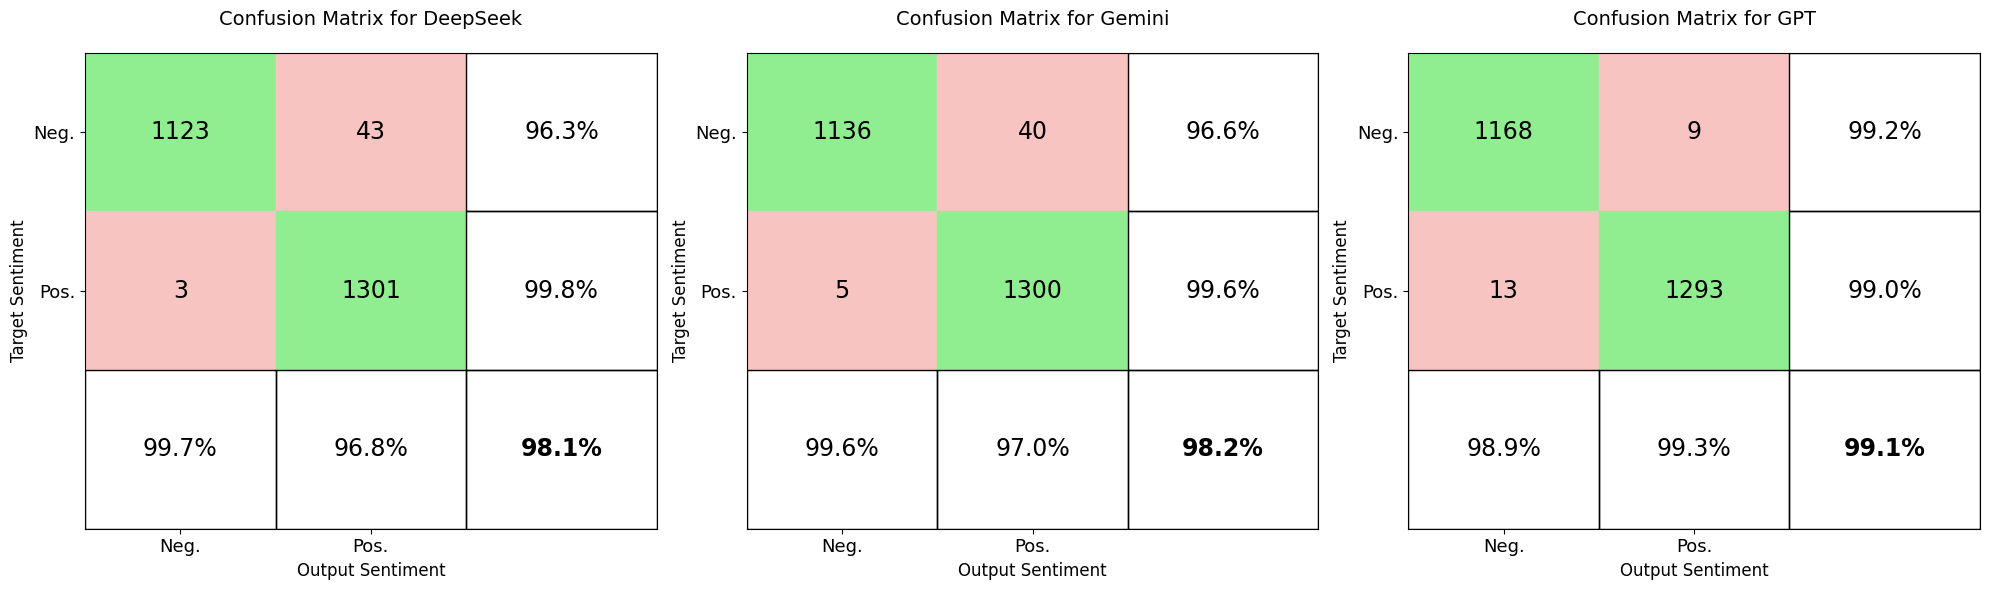

time: 1.39 s (started: 2025-04-30 04:59:13 +00:00)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Kolom yang dibandingkan dengan 'label'
output_columns = ["DeepSeek_Sentiment", "Gemini_Sentiment", "GPT_Sentiment"]

# Membuat grid 1x3 untuk 3 confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 baris, 3 kolom

for i, output_column in enumerate(output_columns):
    cm = confusion_matrix(df['label'], df[output_column], labels=[0, 1])
    total_samples = cm.sum()
    cm_percent = cm / total_samples * 100

    row_accuracy = np.diag(cm) / np.sum(cm, axis=1) * 100
    col_accuracy = np.diag(cm) / np.sum(cm, axis=0) * 100
    overall_accuracy = np.sum(np.diag(cm)) / total_samples * 100

    ax = axes[i]

    colors = np.full(cm.shape, "#f8c4c1")
    for j in range(cm.shape[0]):
        colors[j, j] = '#90EE90'

    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            ax.add_patch(plt.Rectangle((k, j), 1, 1, color=colors[j, k], edgecolor='black', lw=1))
            ax.text(k + 0.5, j + 0.5, f"{cm[j, k]}", ha='center', va='center', fontsize=17)

    for j in range(cm.shape[0]):
        ax.text(cm.shape[1] + 0.5, j + 0.5, f"{row_accuracy[j]:.1f}%", ha='center', va='center', fontsize=17)
        ax.add_patch(plt.Rectangle((cm.shape[1], j), 1, 1, fill=False, edgecolor='black', lw=1))

    for k in range(cm.shape[1]):
        ax.text(k + 0.5, cm.shape[0] + 0.5, f"{col_accuracy[k]:.1f}%", ha='center', va='center', fontsize=17)
        ax.add_patch(plt.Rectangle((k, cm.shape[0]), 1, 1, fill=False, edgecolor='black', lw=1))

    ax.text(cm.shape[1] + 0.5, cm.shape[0] + 0.5, f"{overall_accuracy:.1f}%", ha='center', va='center',
            fontsize=17, fontweight='bold')
    ax.add_patch(plt.Rectangle((cm.shape[1], cm.shape[0]), 1, 1, fill=False, edgecolor='black', lw=1))

    ax.set_ylabel("Target Sentiment", fontsize=12)
    ax.set_xlabel("Output Sentiment", fontsize=12)

    ax.set_xticks(np.arange(cm.shape[1]) + 0.5)
    ax.set_xticklabels(['Neg.', 'Pos.'], fontsize=13)
    ax.set_yticks(np.arange(cm.shape[0]) + 0.5)
    ax.set_yticklabels(['Neg.', 'Pos.'], fontsize=13)
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    ax.set_xlim([0, cm.shape[1] + 1])
    ax.set_ylim([0, cm.shape[0] + 1])
    ax.invert_yaxis()

    ax.set_title(f"Confusion Matrix for {output_column.replace('_Sentiment','')}", fontsize=14, pad=20)

plt.tight_layout()
plt.show()
